# Scanpy processing of MOC2 mouse data from Paul Lambert lab: Understanding tumor outcomes in K17 knockout mice compared to WT

Purpose of this analysis: 
The purpose of this analysis is to look at the tumor microenvironment in mice, from data collected from the Lambert lab. We will be comparing the TME between K17 knockout mice and WT mice. Ultimately, the goal is to understand whether the mouse models of head and neck cancer are translational to human studies. There is more experimental flexibility in mice, so the goal is to understand whether these mouse models can reasonably translate to humans. 

Experimental design: 
*2 WT MOC2 mice
*2 K17KO MOC2 mice (K17 is stress keratin 17, these mice have the knockout to see if there is a more beneficial outcome by knocking out this gene)

Sample collection: 
From each mouse's tumor, CD45+ cells (B cells) were isolated and prepared for single cell RNA seq (scRNA-seq). 

Data collection: 
These samples were sequenced using the 10x genomics platform. The output from the sequencing are paired end FASTQ files, which contain sequences along with their corresponding quality scores as assigned from the sequencing instrument. One paired-end file contains the barcode, and the other paired-end file contains the poly-A tail. 

Pre-processing: 
Pre-processing was completed using Cell Ranger from 10x Genomics. In short, Cell Ranger assessed the FASTQ files mentioned above for quality, and output a matrix assessing the count of each intersection of features and cells. So, you'll get a count of how many of each gene were found in each cell. The Cell Ranger output matrix actually consists of three different files. 

features.tsv

barcodes.tsv

matrix.mtx

features.tsv 
-for each feature, its feature ID and name are stored in the first and second column
-the type of feature is listed in the third column

barcodes.tsv
-barcode sequences correspond to column indices (Ex. AAACATACAAAACG-1)
-the barcode is a chromium cellular barcode sequence that is error corrected and confirmed against a list of known-good barcode sequences
-the number after the dash corresponds to GEM wells, which is used to virtualize barcodes in order to achieve a higher barcode diversity when combining samples generated from a single GEM chip channel. 

matrix.mtx
-top three lines are header lines
-third line contains total # of rows in all 3 files in this folder
-lines 4 and onward have 3 columns 
    1. Gene ID index
    2. Cell ID index
    3. Total UMI count per cell/gene combination
-gene ID and cell ID indices correspond to entries in the barcodes.tsv and genes.tsv files. 
-index in matrix (MEX) files is 1-based, not 0-based

Example line in the mtx file: 

154 1 21

154 = feature on line 154 in features.csv

1 = cell-barcode at line 1 in barcodes.tsv

21 = UMI count = 21 for the gene and barcode combination

# Importing Relevant Packages

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import os
import scprep
import harmonypy as hm
import anndata as ad
import subprocess
import scrublet as scr

# Settings and Configuration

In [2]:
#verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3

#printing headers
sc.logging.print_header()

#setting our figure parameters
sc.settings.set_figure_params(dpi=80, facecolor='white')

#output folder
output = "/Users/athenagolfinos/Desktop/MOC2_results/All_data/"

#specifying the name of our results file
results_file = output + "moc2.h5ad"

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.20.1 scipy==1.6.2 pandas==1.2.4 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.7.1 leidenalg==0.7.0


# Specifying input variables

In [3]:
#this should be the overarching directory where all data is located in subfolders
root = "/Users/athenagolfinos/Desktop/MOC2_data/"

#this should be the exact sub-folder you'd like to investigate 
#for example, "MOC2K17K01_CellRanger_CountMatrix"
#this is one specific mouse used in a set of four mice 
experiment1 = "MOC2WT1_CelllRanger_CountMatrix"
experiment2 = "MOC2WT2_CelllRanger_CountMatrix"
experiment3 = "MOC2K17KO1_CelllRanger_CountMatrix"
experiment4 = "MOC2K17KO2_CelllRanger_CountMatrix"

# Reading in and analyzing the count matrix

In [4]:
#this path should specify the directory where the '.matx' file is located
adata1 = sc.read_10x_mtx(root + experiment1, 
                         var_names='gene_symbols', #variables-axis index
                         cache=True) # writing a cache file for faster subsequent reading

adata2 = sc.read_10x_mtx(root + experiment2, 
                         var_names='gene_symbols', #variables-axis index
                         cache=True) # writing a cache file for faster subsequent reading

adata3 = sc.read_10x_mtx(root + experiment3, 
                         var_names='gene_symbols', #variables-axis index
                         cache=True) # writing a cache file for faster subsequent reading

adata4 = sc.read_10x_mtx(root + experiment4, 
                         var_names='gene_symbols', #variables-axis index
                         cache=True) # writing a cache file for faster subsequent reading
print(adata1)
print(adata2)
print(adata3)
print(adata4)

... reading from cache file cache/Users-athenagolfinos-Desktop-MOC2_data-MOC2WT1_CelllRanger_CountMatrix-matrix.h5ad
... reading from cache file cache/Users-athenagolfinos-Desktop-MOC2_data-MOC2WT2_CelllRanger_CountMatrix-matrix.h5ad
... reading from cache file cache/Users-athenagolfinos-Desktop-MOC2_data-MOC2K17KO1_CelllRanger_CountMatrix-matrix.h5ad
... reading from cache file cache/Users-athenagolfinos-Desktop-MOC2_data-MOC2K17KO2_CelllRanger_CountMatrix-matrix.h5ad


AnnData object with n_obs × n_vars = 12285 × 32285
    var: 'gene_ids', 'feature_types'
AnnData object with n_obs × n_vars = 5964 × 32285
    var: 'gene_ids', 'feature_types'
AnnData object with n_obs × n_vars = 4093 × 32285
    var: 'gene_ids', 'feature_types'
AnnData object with n_obs × n_vars = 3204 × 32285
    var: 'gene_ids', 'feature_types'


# Showing the genes that yield the highest fraction of counts for each cell, across all cells

normalizing counts per cell
    finished (0:00:00)


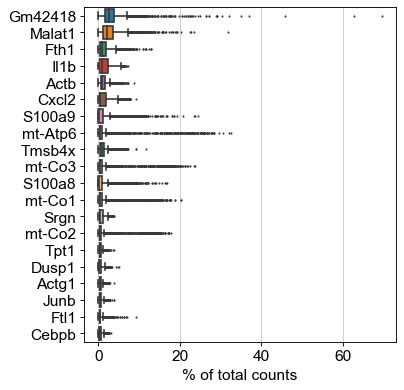

normalizing counts per cell
    finished (0:00:00)


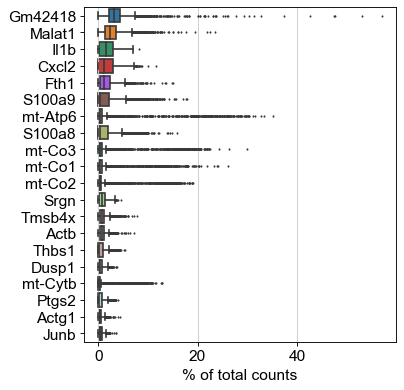

normalizing counts per cell
    finished (0:00:00)


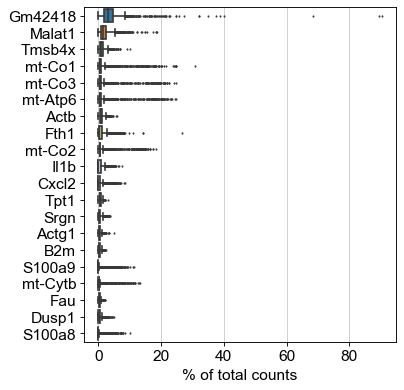

normalizing counts per cell
    finished (0:00:00)


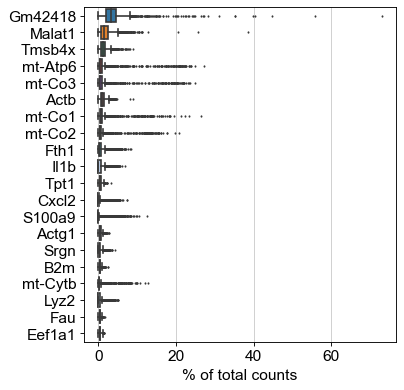

In [5]:
sc.pl.highest_expr_genes(adata1, n_top=20, )
sc.pl.highest_expr_genes(adata2, n_top=20, )
sc.pl.highest_expr_genes(adata3, n_top=20, )
sc.pl.highest_expr_genes(adata4, n_top=20, )


# Basic Filtering to eliminate cells and genes with very low counts

In [6]:
sc.pp.filter_cells(adata1, min_genes=200)
sc.pp.filter_genes(adata1, min_cells=3)

sc.pp.filter_cells(adata2, min_genes=200)
sc.pp.filter_genes(adata2, min_cells=3)

sc.pp.filter_cells(adata3, min_genes=200)
sc.pp.filter_genes(adata3, min_cells=3)

sc.pp.filter_cells(adata4, min_genes=200)
sc.pp.filter_genes(adata4, min_cells=3)

print(adata1)
print(adata2)
print(adata3)
print(adata4)

filtered out 80 cells that have less than 200 genes expressed
filtered out 14265 genes that are detected in less than 3 cells
filtered out 197 cells that have less than 200 genes expressed
filtered out 15090 genes that are detected in less than 3 cells
filtered out 76 cells that have less than 200 genes expressed
filtered out 15995 genes that are detected in less than 3 cells
filtered out 75 cells that have less than 200 genes expressed
filtered out 15900 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 12205 × 18020
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'
AnnData object with n_obs × n_vars = 5767 × 17195
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'
AnnData object with n_obs × n_vars = 4017 × 16290
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'
AnnData object with n_obs × n_vars = 3129 × 16385
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'


# Assessing and assembling quality control metrics

A large part of this process will consist of identifying cells with a large fraction of mitochondrial genes. Now, why is this important? 

To quote from the Scanpy documentation: 
"Let’s assemble some information about mitochondrial genes, which are important for quality control.

Citing from “Simple Single Cell” workflows (Lun, McCarthy & Marioni, 2017):

    High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane."

... storing 'feature_types' as categorical


WT #1


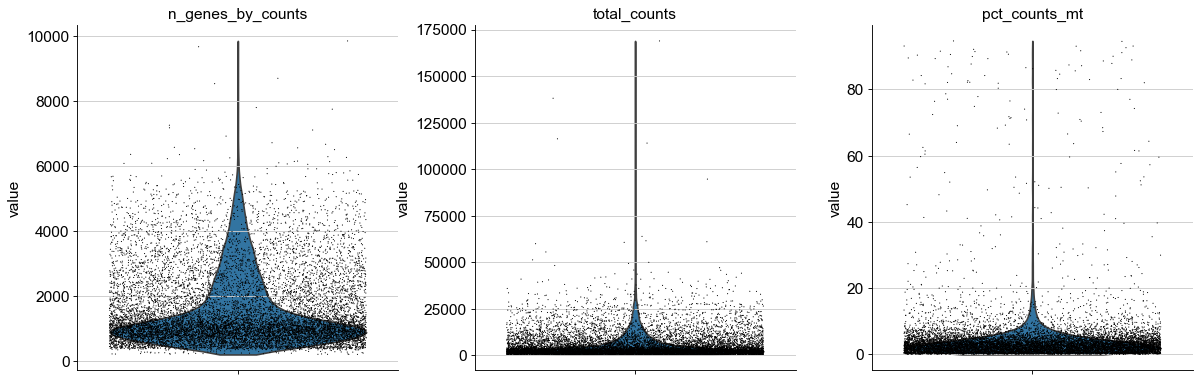

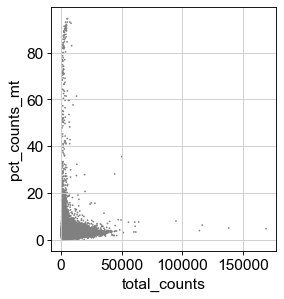

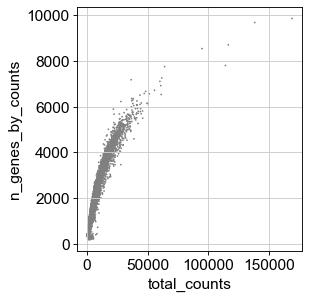

... storing 'feature_types' as categorical


WT #2


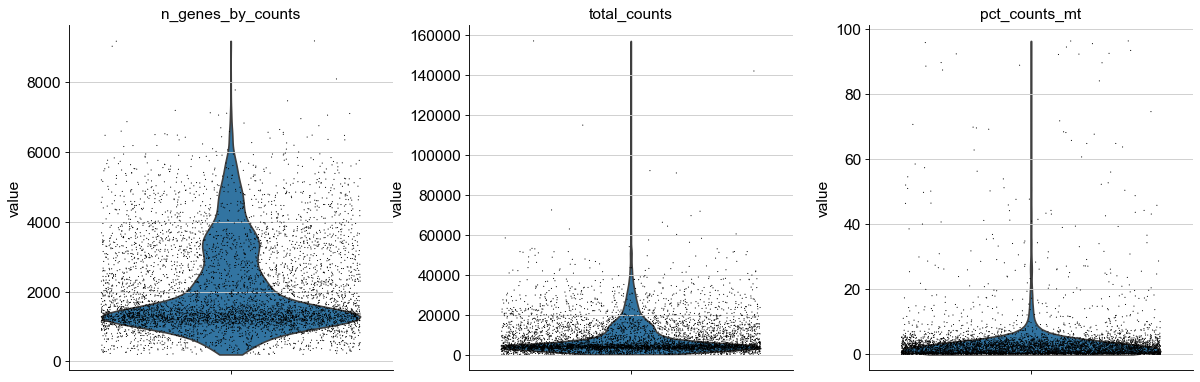

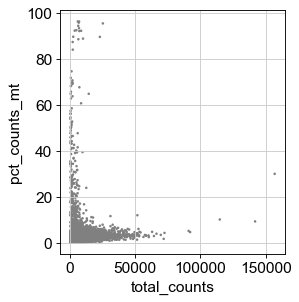

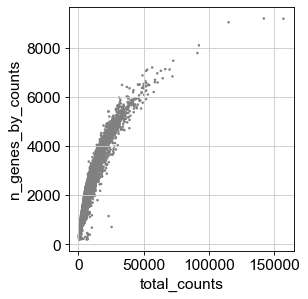

... storing 'feature_types' as categorical


K17KO#1


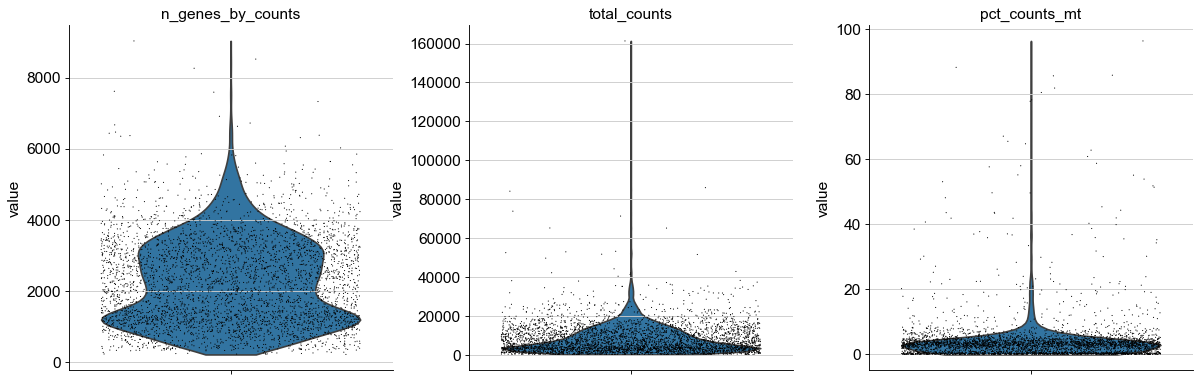

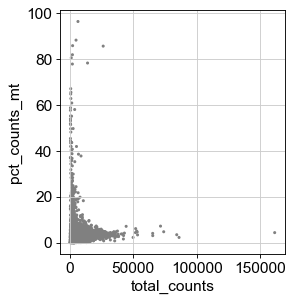

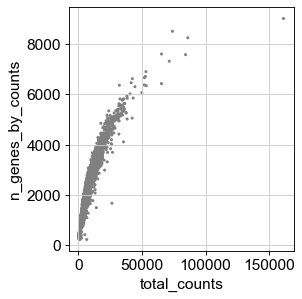

... storing 'feature_types' as categorical


K17KO#2


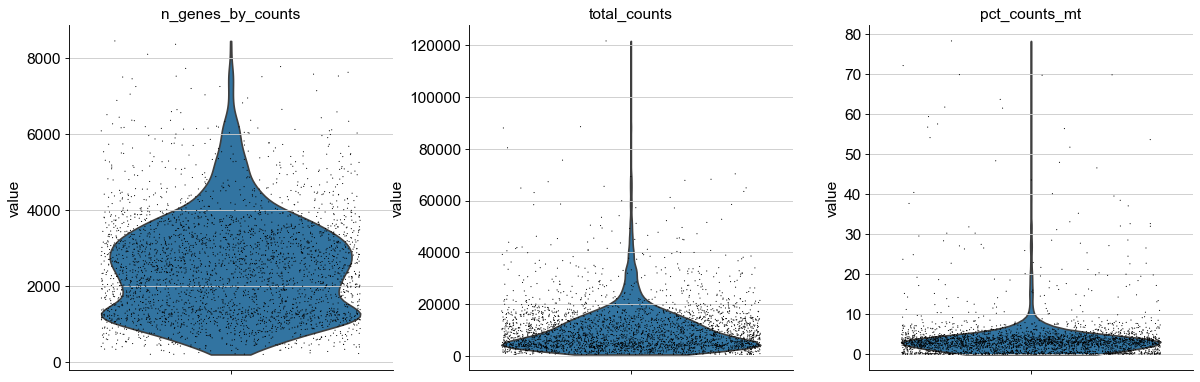

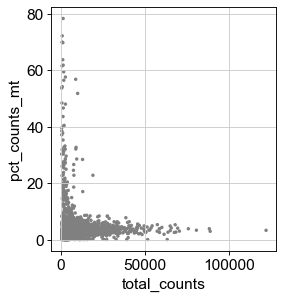

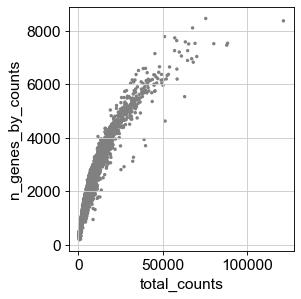

In [7]:
#now, we want to learn more about the mitochondrial genes, which we indicate as 'mt'
#this looks for genes in our matrix that start with 'MT', as that is an indicator that it's a mitochondrial gene
adata1.var['mt'] = adata1.var_names.str.startswith('mt-') 
adata2.var['mt'] = adata2.var_names.str.startswith('mt-')
adata3.var['mt'] = adata3.var_names.str.startswith('mt-')
adata4.var['mt'] = adata4.var_names.str.startswith('mt-')

#this calculates metrics about the mitocondrial genes
sc.pp.calculate_qc_metrics(adata1, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata2, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata3, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata4, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

print("WT #1")
sc.pl.violin(adata1, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(adata1, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata1, x='total_counts', y='n_genes_by_counts')

print("WT #2")
sc.pl.violin(adata2, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(adata2, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata2, x='total_counts', y='n_genes_by_counts')

print("K17KO#1")
sc.pl.violin(adata3, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(adata3, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata3, x='total_counts', y='n_genes_by_counts')

print("K17KO#2")
sc.pl.violin(adata4, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(adata4, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata4, x='total_counts', y='n_genes_by_counts')


# Slicing/filtering data based on quality control metrics

The parameters (shown in green in the cell right below this) should be adjusted based on your observations from the scatter plots in the cell above this one. The best way to choose a threshold is based on where you start to see a clear separation between the large cluster of data, and when you start to see individual cells quite clearly. You don't want to filter too many cells, so try to pick a threshold that is somewhere between where the cells start to taper off and where the cells are very clear deviants. 

In [8]:
# now, we want to filter our n genes by counts data set by selecting a threshold (shown in green)
#the number in green is the maximum count that you want to keep--everything above this value will be eliminated
adata1 = adata1[adata1.obs.n_genes_by_counts < 7000, :]
adata2 = adata2[adata2.obs.n_genes_by_counts < 7000, :]
adata3 = adata3[adata3.obs.n_genes_by_counts < 7000, :]
adata4 = adata4[adata4.obs.n_genes_by_counts < 7000, :]

#we also want to filter our percent mitochondrial genes counts data set by selecting a threshold (shown in green)
#the number in green is the maximum percentage that you want to keep--everything above this value will be eliminated
adata1 = adata1[adata1.obs.pct_counts_mt < 10, :]
adata2 = adata2[adata2.obs.pct_counts_mt < 10, :]
adata3 = adata3[adata3.obs.pct_counts_mt < 10, :]
adata4 = adata4[adata4.obs.pct_counts_mt < 10, :]

print(adata1)
print(adata2)
print(adata3)
print(adata4)

View of AnnData object with n_obs × n_vars = 11579 × 18020
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
View of AnnData object with n_obs × n_vars = 5478 × 17195
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
View of AnnData object with n_obs × n_vars = 3812 × 16290
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
View of AnnData object with n_obs × n_vars = 2985 × 16385
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    va

# Normalizing the data to X reads per cell 

We now want to filter the remaining data set so we can have a set number of reads per cell. This will give us a comparable number of counts per cell. You want your target normalization number to be then number in green below: this can be adjusted based on your particular data set if necessary. 

Scientific notation value examples: 

1e3 = 1,000 counts per cell

1e4 = 10,000 counts per cell

1e5 = 100,000 counts per cell

In [9]:
#normalizing our data set to a set number of counts per cell. This should be the number in green below
sc.pp.normalize_total(adata1, target_sum=1e4)
sc.pp.normalize_total(adata2, target_sum=1e4)
sc.pp.normalize_total(adata3, target_sum=1e4)
sc.pp.normalize_total(adata4, target_sum=1e4)

/Users/athenagolfinos/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


# Logarithmize our normalized cell count data

In [10]:
sc.pp.log1p(adata1)
sc.pp.log1p(adata2)
sc.pp.log1p(adata3)
sc.pp.log1p(adata4)

# Identifying highly variable genes

In [11]:
sc.pp.highly_variable_genes(adata1, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(adata3, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(adata4, min_mean=0.0125, max_mean=3, min_disp=0.5)

adata1

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 11579 × 18020
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

# Plotting highly variable genes

WT #1


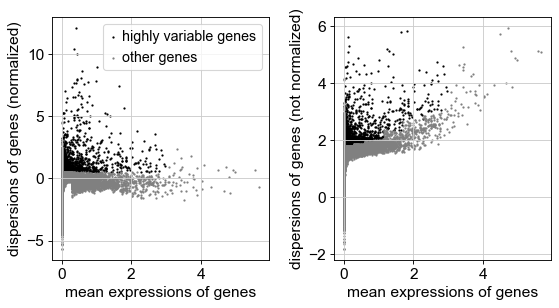

WT 1 highly variable genes: 2265
WT #2


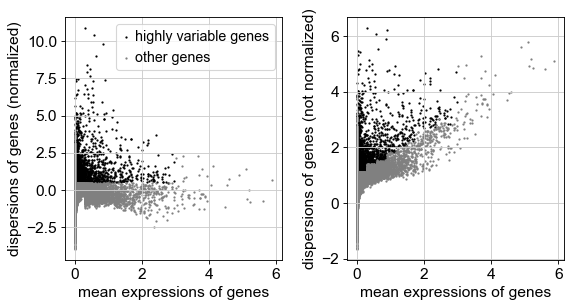

WT 2 highly variable genes: 2596
K17KO #1


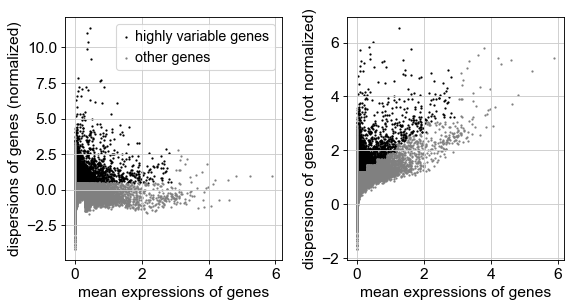

K17KO1 highly variable genes: 3106
K17KO #2


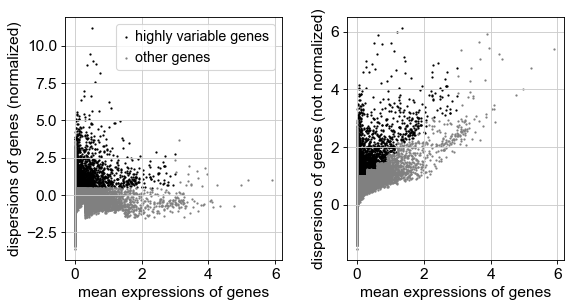

K17KO1 highly variable genes: 3142


In [24]:
print("WT #1")
sc.pl.highly_variable_genes(adata1)
var1 = adata1.var.highly_variable
print("WT 1 highly variable genes: %d"%sum(var1))

print("WT #2")
sc.pl.highly_variable_genes(adata2)
var2 = adata2.var.highly_variable
print("WT 2 highly variable genes: %d"%sum(var2))

print("K17KO #1")
sc.pl.highly_variable_genes(adata3)
var3 = adata3.var.highly_variable
print("K17KO1 highly variable genes: %d"%sum(var3))

print("K17KO #2")
sc.pl.highly_variable_genes(adata4)
var4 = adata4.var.highly_variable
print("K17KO1 highly variable genes: %d"%sum(var4))

# Setting the raw attribute to the current version of the matrix

Information from the Scanpy tutorial as to why this step is important: 

"Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object."

Note: Should you need to get back to the AnnData version in .raw, you can call .raw.to_adata().

Another note from the Scanpy tutorial: 
"If you don’t proceed below with correcting the data with sc.pp.regress_out and scaling it via sc.pp.scale, you can also get away without using .raw at all."

In [13]:
adata1.raw = adata1
adata2.raw = adata2
adata3.raw = adata3
adata4.raw = adata4

# Removing doublets

In [14]:
#scrub1 = scr.Scrublet(adata1.raw.X, expected_doublet_rate = 0.08)
#scrub2 = scr.Scrublet(adata2.raw.X, expected_doublet_rate = 0.04)
#scrub3 = scr.Scrublet(adata3.raw.X, expected_doublet_rate = 0.03)
#scrub4 = scr.Scrublet(adata4.raw.X, expected_doublet_rate = 0.02)

#doublet_scores, predicted_doublets = scrub1.scrub_doublets(min_counts=2, min_cells=3, min_gene_variability_pctl=85)
#doublet_scores, predicted_doublets = scrub2.scrub_doublets(min_counts=2, min_cells=3, min_gene_variability_pctl=85)
#doublet_scores, predicted_doublets = scrub3.scrub_doublets(min_counts=2, min_cells=3, min_gene_variability_pctl=85)
#doublet_scores, predicted_doublets = scrub4.scrub_doublets(min_counts=2, min_cells=3, min_gene_variability_pctl=85)

#scrub1.plot_histogram()
#scrub2.plot_histogram()
#scrub3.plot_histogram()
#scrub4.plot_histogram()

sc.external.pp.scrublet(adata1, expected_doublet_rate=0.08, n_prin_comps=50)
sc.external.pp.scrublet(adata2, expected_doublet_rate=0.04, n_prin_comps=50)
sc.external.pp.scrublet(adata3, expected_doublet_rate=0.03, n_prin_comps=50)
sc.external.pp.scrublet(adata4, expected_doublet_rate=0.02, n_prin_comps=50)

adata1 = adata1[adata1.obs.doublet_score < 0.25, :]
adata2 = adata2[adata2.obs.doublet_score < 0.24, :]
adata3 = adata3[adata3.obs.doublet_score < 0.37, :]
adata4 = adata4[adata4.obs.doublet_score < 0.25, :]

print(adata1)
print(adata2)
print(adata3)
print(adata4)

Running Scrublet
filtered out 219 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    Scrublet finished (0:00:09)
Running Scrublet
filtered out 309 genes that are detected in less than 3 cells


Automatically set threshold at doublet score = 0.40
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 44.3%
Overall doublet rate:
	Expected   = 8.0%
	Estimated  = 4.1%


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
/Users/athenagolfinos/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    Scrublet finished (0:00:04)
Running Scrublet
filtered out 216 genes that are detected in less than 3 cells
normalizing counts per cell


Automatically set threshold at doublet score = 0.27
Detected doublet rate = 0.9%
Estimated detectable doublet fraction = 42.8%
Overall doublet rate:
	Expected   = 4.0%
	Estimated  = 2.1%


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
/Users/athenagolfinos/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    Scrublet finished (0:00:02)
Running Scrublet
filtered out 293 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)


Automatically set threshold at doublet score = 0.37
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 10.9%
Overall doublet rate:
	Expected   = 3.0%
	Estimated  = 2.2%


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
/Users/athenagolfinos/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    Scrublet finished (0:00:01)


Automatically set threshold at doublet score = 0.25
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 28.0%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 1.4%
View of AnnData object with n_obs × n_vars = 10915 × 18020
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'scrublet'
View of AnnData object with n_obs × n_vars = 5428 × 17195
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'lo

# Regress out effects of total counts/cell and % mitochondrial genes expressed, and scale data to unit variance

In [15]:
#regress out effects of total counts per cell and % mitochondrial genes expressed
sc.pp.regress_out(adata1, ['total_counts','pct_counts_mt'])
sc.pp.regress_out(adata2, ['total_counts', 'pct_counts_mt'])
sc.pp.regress_out(adata3, ['total_counts', 'pct_counts_mt'])
sc.pp.regress_out(adata4, ['total_counts', 'pct_counts_mt'])

#scale each gene to unit variance. Clip values exceeding SD of 10
sc.pp.scale(adata1, max_value=10)
sc.pp.scale(adata2, max_value=10)
sc.pp.scale(adata3, max_value=10)
sc.pp.scale(adata4, max_value=10)

print(adata1)
print(adata2)
print(adata3)
print(adata4)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:01:49)
regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:01:07)
regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:51)
regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:52)


AnnData object with n_obs × n_vars = 10915 × 18020
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'scrublet'
AnnData object with n_obs × n_vars = 5428 × 17195
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'scrublet'
AnnData object with n_obs × n_vars = 3803 × 16290
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doubl

# Principal component analysis (PCA)

The purpose of the PCA is to reveal the main axes of variation and denoise the data. This process reduces the dimensionality of the data. 

computing PCA
    on highly variable genes
    with n_comps=200
    finished (0:00:04)


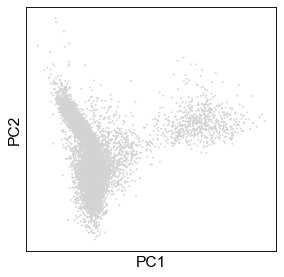

computing PCA
    on highly variable genes
    with n_comps=200
    finished (0:00:02)


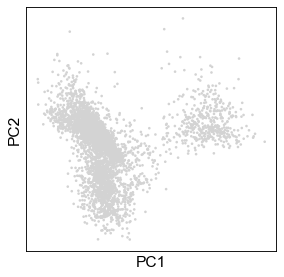

computing PCA
    on highly variable genes
    with n_comps=200
    finished (0:00:02)


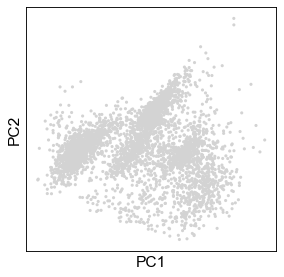

computing PCA
    on highly variable genes
    with n_comps=200
    finished (0:00:01)


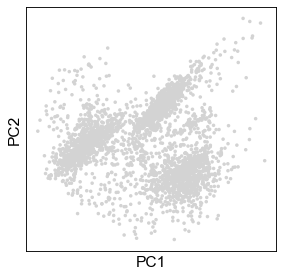

AnnData object with n_obs × n_vars = 10915 × 18020
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'scrublet', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [16]:
#running the PCA calculation process
sc.tl.pca(adata1, n_comps=200, svd_solver='arpack')
#plotting the PCA data
sc.pl.pca(adata1)

sc.tl.pca(adata2, n_comps=200, svd_solver='arpack')
sc.pl.pca(adata2)

sc.tl.pca(adata3, n_comps=200, svd_solver='arpack')
sc.pl.pca(adata3)

sc.tl.pca(adata4, n_comps=200, svd_solver='arpack')
sc.pl.pca(adata4)

adata1

# Integrating our multiple data sets into a single dataset

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
computing PCA
    with n_comps=200
    finished (0:01:13)
... storing 'batch' as categorical


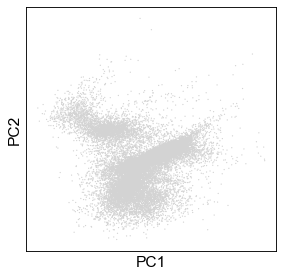

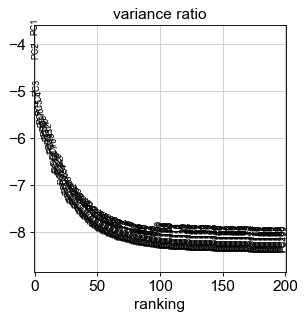

AnnData object with n_obs × n_vars = 23119 × 15302
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'batch'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [17]:
#here we are merging our individual data sets into one but retaining
#their unique identifiers

adata1.obs['batch'] = 'WT'
adata2.obs['batch'] = 'WT'
adata3.obs['batch'] = 'K17_KO'
adata4.obs['batch'] = 'K17_KO'

adata_concat = ad.concat([adata1, adata2, adata3, adata4], join='inner')
#merge='first'

#print("adata_concat")
#print(adata_concat)
#print(adata_concat.X)

#running the PCA calculation process
sc.tl.pca(adata_concat, n_comps=200, svd_solver='arpack', zero_center = False, use_highly_variable=False)
#plotting the PCA data
sc.pl.pca(adata_concat)

#plotting the pca variance ratios for each of the identified PCAs
sc.pl.pca_variance_ratio(adata_concat, n_pcs = 200, log=True)

#saving the result
adata_concat.write(results_file)

adata_concat

# Now, recalculating the PCA with only 50 comps and then integrating the data sets 

In [18]:
#running the PCA calculation process
sc.tl.pca(adata_concat, n_comps=50, svd_solver='arpack', zero_center = False, use_highly_variable=False)

#now, using Harmony to integrate the datasets together
sc.external.pp.harmony_integrate(adata_concat, key='batch')

computing PCA
    with n_comps=50
    finished (0:00:08)
2021-06-23 10:19:10,244 - harmonypy - INFO - Iteration 1 of 10
2021-06-23 10:19:13,210 - harmonypy - INFO - Iteration 2 of 10
2021-06-23 10:19:16,189 - harmonypy - INFO - Iteration 3 of 10
2021-06-23 10:19:18,508 - harmonypy - INFO - Iteration 4 of 10
2021-06-23 10:19:20,032 - harmonypy - INFO - Iteration 5 of 10
2021-06-23 10:19:21,302 - harmonypy - INFO - Iteration 6 of 10
2021-06-23 10:19:22,593 - harmonypy - INFO - Iteration 7 of 10
2021-06-23 10:19:23,708 - harmonypy - INFO - Iteration 8 of 10
2021-06-23 10:19:24,697 - harmonypy - INFO - Converged after 8 iterations


# Computing and embedding the neighborhood graph

Now we are going to compute the neighborhood graph of cells using the PCA representation of the data matrix. We will be using UMAP since it is potentially more faithful to trajectories compared to tSNE plots. 

Standardizing Data across genes.

Found 2 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting data

computing PCA
    with n_comps=100
    finished (0:00:50)
computing neighbors
    using 'X_pca' with n_pcs = 100
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


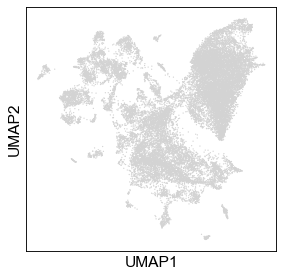

In [22]:
#now, removing batch effects 
sc.pp.combat(adata_concat, key='batch')

#running the PCA calculation process
sc.tl.pca(adata_concat, n_comps=100, svd_solver='arpack', zero_center = False, use_highly_variable=False)

#computing the neighborhood graph
sc.pp.neighbors(adata_concat, n_neighbors=10, n_pcs=100)

#embedding the neighborhood graph

#this particular set of code helps remedy disconnected clusters and connectivity violations, should they exist
#sc.tl.paga(adata_concat)
#sc.pl.paga(adata_concat, plot=False)  
#sc.tl.umap(adata_concat, init_pos='paga')

#computing the UMAP 
sc.tl.umap(adata_concat)

#plotting the UMAP using the raw values (use color =[gene_name_1, gene_name_2, etc] to show plots color coordinated for certain genes)
#sc.pl.umap(adata_concat, color = ['Mrc1', "Tnfrsf18", "Ccr7", 'Bach1', "Creg1"])

#now plotting the UMAP using the scaled and corrected gene expression
sc.pl.umap(adata_concat, use_raw=False)



# Clustering the neighborhood graph

From the Scanpy tutorial: 
"As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by Traag *et al.* (2018). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section"

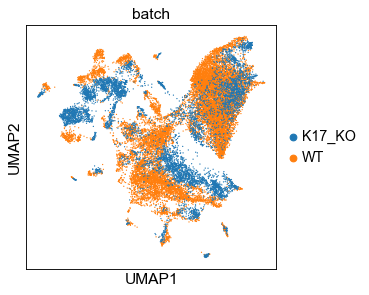

running Leiden clustering
    finished: found 32 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


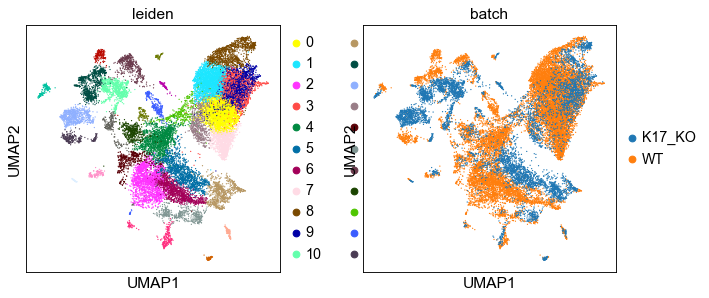

AnnData object with n_obs × n_vars = 23119 × 15302
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'batch', 'leiden'
    uns: 'pca', 'neighbors', 'umap', 'batch_colors', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [23]:
#plotting the Leiden graph clusters
sc.pl.umap(adata_concat, color=['batch'])

#now, removing batch effects 
#sc.pp.combat(adata_concat, key='batch')

#computing the Leiden graph clusters
sc.tl.leiden(adata_concat)

#plotting again, hopefully without batch effects
sc.pl.umap(adata_concat, color=['leiden', 'batch'])

#saving this result
adata_concat.write(results_file)

adata_concat

# Finding highly differential genes based on Leiden clustering: Wilcoxon rank-sum method

From the Scanpy documentation: 
"Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the .raw attribute of AnnData is used in case it has been initialized before." They state that the easiest way to compute this is using the T-test, however they recommend using Wilcoxon-Rank for publications. 

"The result of a Wilcoxon rank-sum (Mann-Whitney-U) test is very similar. We recommend using the latter in publications, see e.g., Sonison & Robinson (2018)"

When they refer to the "latter", they are referring to the Wilcoxon rank-sum compared to the T-test. 

In [21]:
#computing the highly differential genes in each group using the leiden results and comparing via Wilcoxon rank-sum
sc.tl.rank_genes_groups(adata_concat, 'leiden', method='wilcoxon')

#we are using the same gene ranking test here, except with a different method. Logistic regression instead of Wilcoxon rank-sum
#sc.tl.rank_genes_groups(adata_concat, 'leiden', method='logreg')

#will look at 25 top genes in each cluster
sc.pl.rank_genes_groups(adata_concat, n_genes=25, sharey=False)

#saving this data to our results file
adata_concat.write(results_file)

#reloading the object saved with the Wilcoxon rank-sum test result
adata_concat = sc.read(results_file)

#showing a list of the top 10 ranked genes per cluster in a dataframe
df1= pd.DataFrame(adata_concat.uns['rank_genes_groups']['names']).head(5)

#saving this file so we can 
df1.to_csv( output + "top5genespercluster.csv")
print(df1)

ranking genes


KeyboardInterrupt: 

# Assigning and scoring marker genes based on the most prominent genes in each cluster

Now we want to provide a dictionary of our marker genes so we can identify which cells relate to which clusters as best as we can. 

In [ ]:
sc.tl.leiden(adata_concat, key_added='clusters')

#dictionary of our marker genes for each cluster
marker_genes_dict = {'Neutrophil': ['Csf3r', 'Csf1r', 'S100a8', 'Siglecf', 'S100a9', 'Cebpe', 'Ctsg', 'Gfi1'], 
                    'Monocyte/Macrophage': ['Cxcl9', 'Adgre1', 'Spp1', 'Cd14', 'Csf1r', 'Irf8'], 
                    'Mast cells': ['Tpsab1', 'Kit'], 
                    'Dendritic Cells': ['Clec9a', 'Ccr7', 'Xcr1', 'Fcer1a', 'Sdc1'], 
                    'B cells': ['Cd19', 'Ms4a1', 'Cd79a'], 
                    'T cells/NK cells': ['Foxp3', 'Cd4', 'Cd3e', 'Cd8a', 'Ncr1']}

#plotting this paper in a summary dot plot
sc.pl.dotplot(adata_concat, marker_genes_dict, 'clusters', dendrogram=True)

#now looking at a heatmap that does not collapse cells like in the previous plot
ax = sc.pl.heatmap(adata_concat, marker_genes_dict, groupby='clusters', cmap='viridis', dendrogram=True)


# Labeling the clusters of cells on the leiden plot

In [ ]:
#creating a dictionary to map cluster to annotation label
cluster2annotation = {
    '0': 'Neutrophils', 
    '1': 'Neutrophils', 
    '2': 'Neutrophils', 
    '3': 'Neutrophils', 
    '4': 'Neutrophils', 
    '5': 'Monocytes/Macrophages', 
    '6': 'Monocytes/Macrophages', 
    '7': 'Monocytes/Macrophages', 
    '8': 'Neutrophils', 
    '9': 'Neutrophils', 
    '10': 'T cells/NK cells', 
    '11': 'Monocytes/Macrophages',
    '12': 'Monocytes/Macrophages', 
    '13': 'T cells/NK cells', 
    '14': 'Neutrophils', 
    '15': 'Monocytes/Macrophages', 
    '16': 'Monocytes/Macrophages', 
    '17': 'Monocytes/Macrophages', 
    '18': 'T cells/NK cells', 
    '19': 'Monocytes/Macrophages', 
    '20': 'Mast cells', 
    '21': 'Dendritic cells', 
    '22': 'Neutrophils', 
    '23': 'T cells/NK cells',
    '24': 'Monocytes/Macrophages',
    '25': 'T cells/NK cells', 
    '26': 'B cells',
    '27': 'Neutrophils',
    '28': 'Neutrophils',
    '29': 'Dendritic cells',
    '30': 'Monocytes/Macrophages',
    '31': 'Neutrophils'
}

#add a new '.obs' column called 'cell type' by mapping clusters to annotation using pandas 'map' function
adata_concat.obs['cell type'] = adata_concat.obs['clusters'].map(cluster2annotation).astype('category')

sc.pl.umap(adata_concat, color = 'cell type', 
          frameon=False, legend_fontsize=10, legend_fontoutline=2)

# Clustree visualization of leiden cluster data

Since there is no clustree version for Python, I will be implementing an R script that runs clustree and then imports the results to Python. 

In [ ]:
CLUSTREE_SCRIPT = "/Users/athenagolfinos/Desktop/Clustree_script.R"
ADATA_PATH = "/Users/athenagolfinos/Desktop/MOC2_results/All_data/moc2.h5ad"
CLUSTREE_OUT = "/Users/athenagolfinos/Desktop/MOC2_results/All_data/"

singler_run_clusters = subprocess.call("Rscript {CLUSTREE_SCRIPT} {ADATA_PATH} {CLUSTREE_OUT + 'clustree.png'}", shell=True)

filename= CLUSTREE_OUT + "clustree.png"
print(filename)